# A First look at the Data

## Introduction

In this section some basic analysis will be done in order to explain the structure of the data and perform a few sanity checks. Examples of simple plots of the raw data will be provided.

Import the required modules:

In [4]:
import mne
import os
import numpy as np
import os.path as op
import warnings
import inspect
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)

warnings.filterwarnings('ignore')

#### The resampled data is saved as per the BIDS Format in the Sub1_BIDS folder. To import the data in this workspace the following steps will be followed.

### File overview
The chapter relies on the input file (embedded in the BIDS structure)

```
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```

## Loading the BIDS Data

The first step is to prepare the data for reading. The OPM data, which has been organized according to the BIDS format, will be used in this section. This involves setting the `data_path` which defines the MNE BIDS folder.

Specify the BIDS parameters. The <code><a>data_path</a></code> is dependent on where you downloaded and stored the data. 

In [5]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

data_path='C:/Users/rakshita/Documents/Sub_OJ_new'
#data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'

bids_root = op.join(data_path, "Fieldline_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
                     task=task, run=run, suffix=meg_suffix, 
                     extension=meg_extension, root=bids_root)

After the path have been defined the data can be read:

In [7]:
print(bids_path)
raw = read_raw_bids(bids_path=bids_path, 
                    verbose=False,
                    extra_params={'preload':True})

C:/Users/rakshita/Documents/Sub_OJ_new/Fieldline_Spatt_BIDS/sub-01/ses-01/sub-01_ses-01_task-SpAtt_run-01_meg.fif


## Inspecting at the Data


To obtain some basic information from the `.fif` file write:

In [8]:
print(raw)

<Raw | sub-01_ses-01_task-SpAtt_run-01_meg.fif, 69 x 2408520 (2408.5 s), ~1.24 GiB, data loaded>


The dataset has a size of 1.24 GB and spans a total recording duration of 2408.5 seconds. After downsampling to 1000 Hz, this yields 2408530 sample points across the entire recording. The data were collected from 69 channels, comprising 68 magnetometer sensors and 1 stimulus channels.

To get some additional information:

In [9]:
print(raw.info)

<Info | 18 non-empty values
 bads: []
 ch_names: L102_bz-s73, L104_bz-s80, L106_bz-s84, L108_bz-s77, L110_bz-s76, ...
 chs: 68 Magnetometers, 1 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 6 items (3 Cardinal, 3 HPI)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 gantry_angle: 0.0
 highpass: 0.1 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: 2011-06-30 16:23:48 UTC
 meas_id: 4 items (dict)
 nchan: 69
 proj_id: 1 item (ndarray)
 proj_name: mne_anonymize
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
 xplotter_layout: None
>


This information shows the important parameters of the dataset. For instance, the sampling frequency is 1000 Hz (sfreq). The data was lowpass filtered at 250.0 Hz (lowpass) prior to downsampling. The experimenter is anonymised and the recording time and date removed to comply with GDPR rules.

**Question 1:** What role does the 250 Hz analogue low‑pass filter play in the data acquisition process? (See Chapter 3 in [1])

### Understanding the sensor layout

As a first step inspect the sensors information by plotting the labels of the first 40 sensors:

In [49]:
ch_names = raw.info['ch_names']
print(ch_names[1:40])

['L104_bz-s80', 'L106_bz-s84', 'L108_bz-s77', 'L110_bz-s76', 'L112_bz-s44', 'L114_bz-s50', 'L116_bz-s37', 'L201_bz-s86', 'L205_bz-s87', 'L207_bz-s75', 'L209_bz-s52', 'L210_bz-s65', 'L211_bz-s46', 'L213_bz-s48', 'L215_bz-s47', 'L302_bz-s83', 'L304_bz-s71', 'L306_bz-s67', 'L307_bz-s42', 'L309_bz-s68', 'L310_bz-s45', 'L312_bz-s49', 'L401_bz-s85', 'L403_bz-s81', 'L405_bz-s82', 'L409_bz-s43', 'L503_bz-s79', 'L505_bz-s74', 'L507_bz-s70', 'L509_bz-s51', 'L603_bz-s78', 'L605_bz-s72', 'L607_bz-s9', 'R102_bz-s4', 'R104_bz-s11', 'R106_bz-s3', 'R108_bz-s12', 'R110_bz-s1', 'R112_bz-s39']


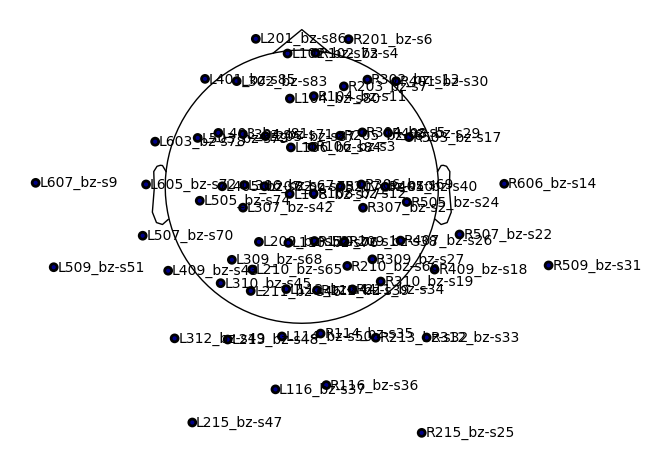

In [43]:
raw.plot_sensors(kind='topomap', show_names=True,to_sphere=True);

### Estimating the power spectra
The data object (raw) allows for a simple inspection of the data by calculating the spectra: As a first step calculate the PSDs of all the OPM sensors for 0-120 HZ frequency range using the MNE functions. Also note that the sampling frequency 1000 Hz and therefore chose $N_{FFT}$ = 2000 to achieve a 0.5 Hz spectral resolution. A Welch method is use with 50% overlapping time-windows. Per default a Hamming taper is applied to each time-window prior to calculation the Fourier transformation.

In [45]:
n_fft = 2000
raw_PSD = raw.compute_psd(method="welch", fmin=0.0, fmax=120, picks='mag', n_fft=n_fft, n_overlap=int(n_fft/2))

Effective window size : 2.000 (s)


To plot the PSDs:

Plotting power spectral density (dB=True).


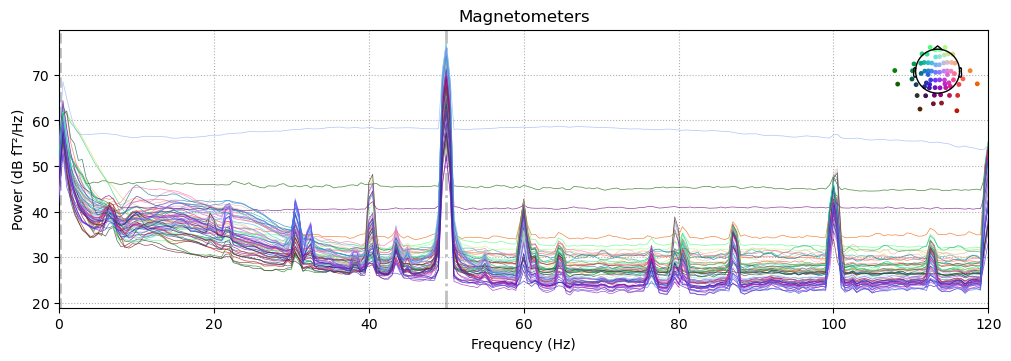

In [46]:
%matplotlib inline  
raw_PSD.plot(exclude='bads',picks='mag');

Note the 50 Hz line noise. The frequency of the line noise is 50 Hz in European countries including Russia as well as Asian countries including India and China. It is 60 in South Korea as well as South and North America. In Japan it will be either 50 or 60 Hz depending on the region.

## Inspecting the raw data using the interactive data browser

It is also possible to browse the data using an interactive plot. This will here be illustrated for the OPM Z sensors sensitive to the radial fields:


In [47]:
%matplotlib qt
raw.plot(duration=10, title='Raw', picks='mag');

Using qt as 2D backend.


This will open the plot in a new window. Use the arrow keys to move over channels and time. Click on the help button for more information.

**Question 3:** Scroll through the OPM data and identify the following artefacts (include screen dumps in the response):

- The left and right cue onsets
- Eye‑blink  
- A muscle contraction (characterised by high‑frequency activity)  
- The cardiac artefact  

In [ ]:
head_radius=0.09